In [1]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.preprocessing.preprocessed_data import PreprocessedData
from epimodel.pymc3_models.base_model import produce_CIs
import numpy as np
import pymc3 as pm
from pymc3.distributions import draw_values, generate_samples

import pandas as pd 
import pickle 

Set Theano Environmental Variables for Parallelisation


In [2]:
import pylab as plt
#%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


In [5]:
ep = EpidemiologicalParameters()

In [6]:
with DefaultModel(data) as model_syn:
    model_syn.build_model(**ep.get_model_build_dict())

In [47]:
with model_syn: 
    
    point = {
        'CM_Alpha' : np.array([.0,.05,.1,.15,.2,.25,.3,.35,.4]),
        'InitialSizeCases_log' : -10 *np.ones((41,1)), 
        'InitialSizeDeaths_log' : -10 *np.ones((41,1)), 
        #'RegionLogR_noise' : .1*np.ones(41),
        'HyperRVar' : 1
    }
    c = [model_syn.GrowthCases, 
         model_syn.GrowthDeaths, 
         model_syn.RegionR, 
         model_syn.ObservedCases, 
         model_syn.ObservedDeaths, 
         model_syn.RegionLogR_noise, 
         model_syn.InfectedCases ,
         model_syn.InfectedDeaths ,
         model_syn.ExpectedCases ,
         model_syn.ExpectedDeaths ]
    
    synthvalues = draw_values(c, point=point)
    gcases,gdeaths, regionR, ocases, odeaths, regionRnoise,icases,ideaths,ecases, edeaths = synthvalues
    

In [8]:
with open("synthetic_values_simple.pkl", 'wb+') as f:
    pickle.dump(synthvalues, f, pickle.HIGHEST_PROTOCOL)

In [49]:
def synthetic_prep_data(model, data, syn_deaths, syn_cases):
    
    def reverse_shape(synth, indexes, mask):
        a = np.zeros(model.nRs * model.nDs)
        a[indexes] += synth
        a = a.reshape((model.nRs, model.nDs))
        a = np.ma.masked_array(a, mask)
        return a

    
    syntheticNewDeaths = reverse_shape(syn_deaths, 
                                       model.all_observed_deaths,  
                                       data.NewDeaths.mask)
    syntheticNewCases = reverse_shape(syn_cases, 
                              model.all_observed_active,  
                              data.NewCases.mask)
    
    return PreprocessedData(
                 data.Active,
                 data.Confirmed,
                 data.ActiveCMs,
                 data.CMs,
                 data.Rs,
                 data.Ds,
                 data.Deaths,
                 syntheticNewDeaths,
                 syntheticNewCases,
                 data.RNames)




In [10]:
adjustment = np.array([ np.random.choice([.5, 2]) for i in range(model_syn.nRs)])

In [11]:
synth_data_normal = synthetic_prep_data(model_syn, data, odeaths, ocases)
synth_data_adjusted = synthetic_prep_data(model_syn, data, odeaths, ocases)
synth_data_adjusted.NewCases  = synth_data_adjusted.NewCases * adjustment[:, None]

In [35]:
v = model_normal.vars.copy()
v.remove(model_normal.GrowthCasesNoise)
v.remove(model_normal.GrowthDeathsNoise)
v

[CM_Alpha,
 HyperRVar_log__,
 RegionLogR_noise,
 GI_mean,
 GI_sd,
 PsiCases_log__,
 PsiDeaths_log__,
 InitialSizeCases_log,
 CasesDelayMean,
 CasesDelayDisp,
 InitialSizeDeaths_log,
 DeathsDelayMean,
 DeathsDelayDisp]

In [34]:
with DefaultModel(synth_data_normal) as model_normal:
    model_normal.build_model(**ep.get_model_build_dict())

In [13]:
with model_normal:
    model_normal.trace = pm.sample(200, tune=50, cores=1, chains=1, max_treedepth=12, target_accept=0.925, trace=keepvars)
    pm.save_trace(model_normal.trace, "normal_simple", overwrite=True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


Sampling 1 chain for 50 tune and 200 draw iterations (50 + 200 draws total) took 1178 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [14]:
with DefaultModel(synth_data_adjusted) as model_adjusted:
    model_adjusted.build_model(**ep.get_model_build_dict())

In [15]:
with model_adjusted:
    model_adjusted.trace = pm.sample(200, tune=50, cores=1, chains=1, max_treedepth=12, target_accept=0.925, trace=keepvars)
    pm.save_trace(model_adjusted.trace, "adjusted_simple", overwrite=True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DeathsDelayDisp, DeathsDelayMean, InitialSizeDeaths_log, CasesDelayDisp, CasesDelayMean, InitialSizeCases_log, PsiDeaths, PsiCases, GrowthDeathsNoise, GrowthCasesNoise, GI_sd, GI_mean, RegionLogR_noise, HyperRVar, CM_Alpha]


Sampling 1 chain for 50 tune and 200 draw iterations (50 + 200 draws total) took 611 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [57]:
from epimodel.pymc3_models.base_model import produce_CIs

def plot_effect(trace):  
        if hasattr(trace, "points"):
            trace = trace["CMReduction"]
        means, li, ui, lq, uq = produce_CIs(100 * trace)

        N_cms = means.size

        plt.plot([0, 0], [1, -(N_cms)], "--r", linewidth=0.5)
        y_vals = -1 * np.arange(N_cms)
        plt.scatter(means, y_vals, marker="|", color="k")
        for cm in range(N_cms):
            plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.25)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.5)

        plt.xlim([-100, 150])
        xtick_vals = np.arange(-100, 150, 50)
        xtick_str = [f"{x:.0f}%" for x in xtick_vals]
        plt.ylim([-(N_cms - 0.5), 0.5])

#plot_effect(model_normal.trace)
#plot_effect(model_adjusted.trace)

In [59]:
with model_normal:
    nst = pm.load_trace("../../nonsynth_normal_simple")

In [60]:
with model_adjusted:
    ast = pm.load_trace("../../nonsynth_adjusted_simple")

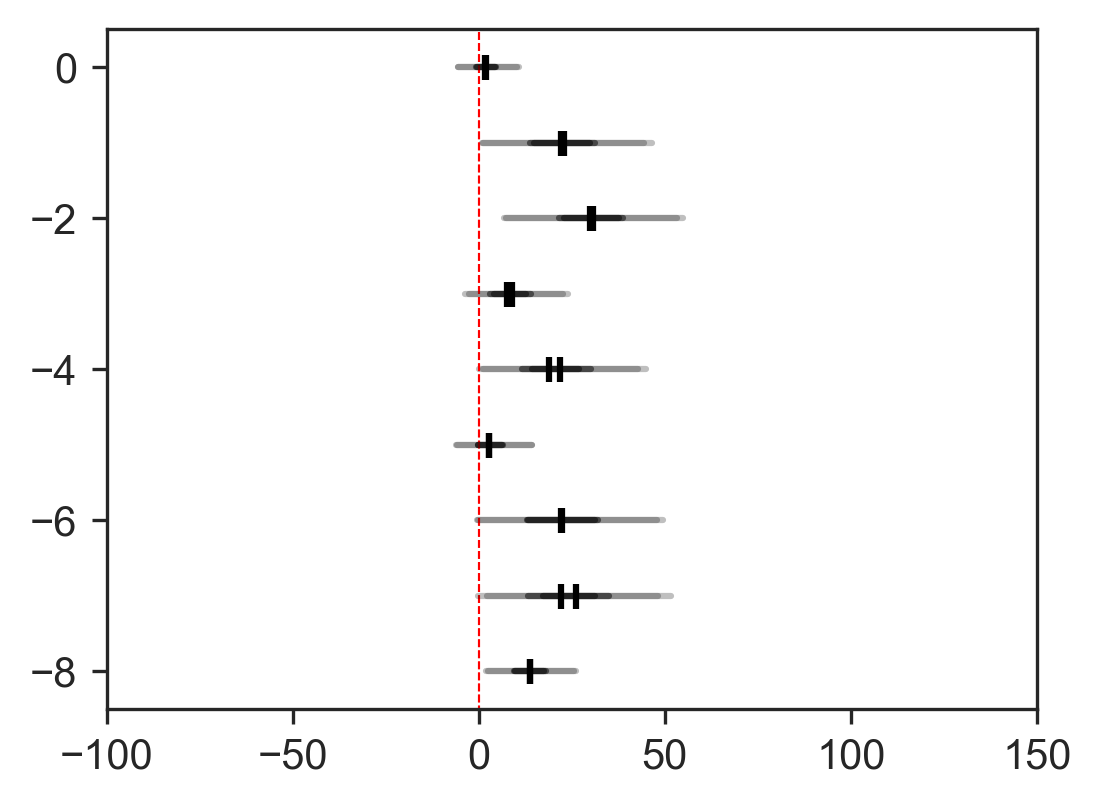

In [61]:
plt.figure(figsize=(4, 3), dpi=300)
plot_effect(nst['CM_Alpha'])
plot_effect(ast['CM_Alpha'])

In [ ]:
nst['CM_Alpha']